influence function sampling 8.138020833333334
Using the influence function supplied.
Including factor of 2 from reflection when computing OPD.
Using the influence function supplied.
Including factor of 2 from reflection when computing OPD.


<Quantity 7089.23076923 mm>

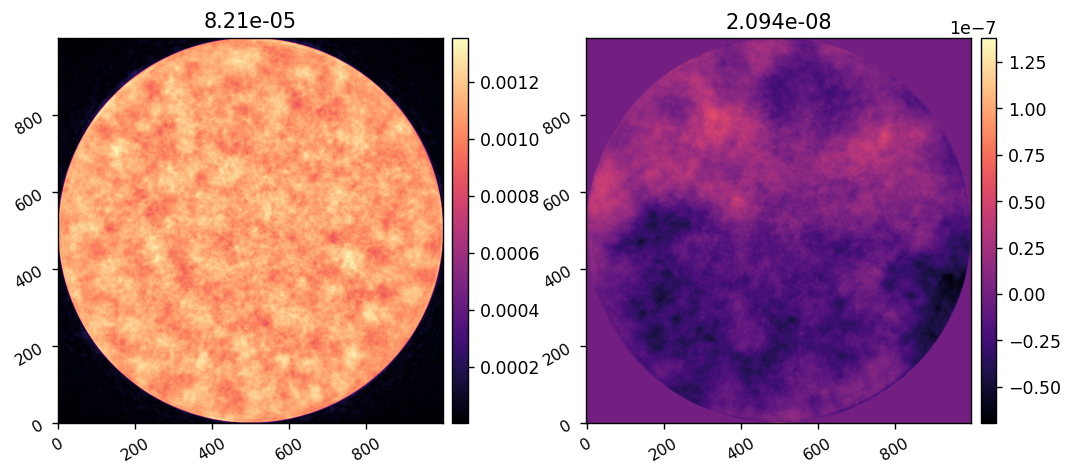

In [1]:
import numpy as np
import astropy.units as u
from astropy.io import fits
from matplotlib.patches import Rectangle, Circle
from pathlib import Path
from IPython.display import clear_output
from importlib import reload

import poppy
import logging, sys
poppy_log = logging.getLogger('poppy')
poppy_log.setLevel('DEBUG')
logging.basicConfig(stream=sys.stdout, level=logging.INFO)
poppy_log.disabled = True

import warnings
warnings.filterwarnings("ignore")

import apra_pop_models
import apra_pop_models.fraunhofer_coro_3 as fraunhofer
from apra_pop_models.math_module import xp, _scipy, ensure_np_array
import apra_pop_models.utils as utils
import apra_pop_models.props as props
import apra_pop_models.efc_utils as efc_utils
import apra_pop_models.efc_2dm as efc
from apra_pop_models.imshows import *

model = fraunhofer.CORO()

FN = 500
optimal_dm1_dm2 = (model.pupil_diam**2/(model.wavelength_c*FN)).to(u.mm)
display(optimal_dm1_dm2)

reload(utils)
WFE = xp.array(fits.getdata('../phase-retrieval-data/post_fpm_wfe_20240503.fits'))
WFE = WFE[0] * xp.exp(1j*2*np.pi*WFE[1]/model.wavelength_c.to_value(u.m))
wfe_amp = xp.abs(WFE)
wfe_opd = xp.angle(WFE)*model.wavelength_c.to_value(u.m)/(2*np.pi)
rms_amp = xp.sqrt(xp.mean(xp.square(wfe_amp[model.APMASK]-xp.mean(wfe_amp[model.APMASK]))))
rms_opd = xp.sqrt(xp.mean(xp.square(wfe_opd[model.APMASK])))
imshow2(wfe_amp, wfe_opd,  f'{rms_amp:.2e}', f'{rms_opd:.3e}')



influence function sampling 8.138020833333334
Using the influence function supplied.
Including factor of 2 from reflection when computing OPD.
Using the influence function supplied.
Including factor of 2 from reflection when computing OPD.
0.8098899774066972


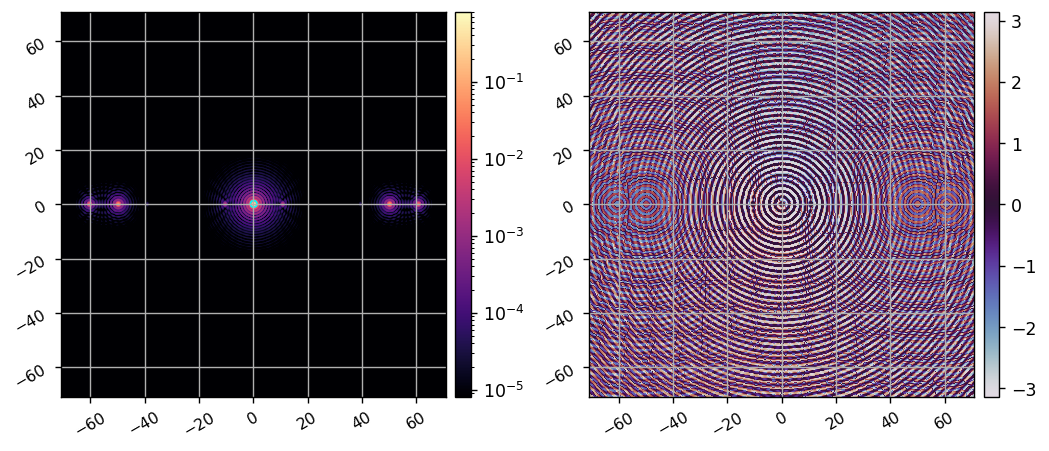

In [14]:
reload(fraunhofer)
reload(apra_pop_models.props)
model = fraunhofer.CORO()
model.npsf = 400
model.reverse_parity = True
# model.WFE = WFE

model.Imax_ref = xp.max(model.snap())

pup_ratio = model.pupil_diam.to_value(u.m)/model.dm_active_diam.to_value(u.m)
xpp = (xp.arange(-model.Nact//2, model.Nact//2) + 1/2)/pup_ratio/0.9
ppx, ppy = xp.meshgrid(xpp,xpp)
amp = 5e-8
separation = 50
comm1 = amp*xp.cos(2*np.pi*(ppx)*separation/model.Nact)*xp.array(model.dm_mask)
comm2 = amp*xp.cos(2*np.pi*(ppx - ppy)*separation/model.Nact)*xp.array(model.dm_mask)
model.set_dm1(ensure_np_array(comm1))
# model.set_dm2(ensure_np_array(comm2))

# model.use_fpm = True

wfs = model.calc_wfs()
im = xp.abs(wfs[-1])**2
print(xp.max(im))
imshow2(im, xp.angle(wfs[-1]), lognorm1=True, vmin1=xp.max(im)/1e5, cmap2='twilight', 
        pxscl=model.psf_pixelscale_lamD, grid=True, 
        patches1=[Circle((model.psf_pixelscale_lamD/2,model.psf_pixelscale_lamD/2), 1.22, fill=False, color='cyan')])


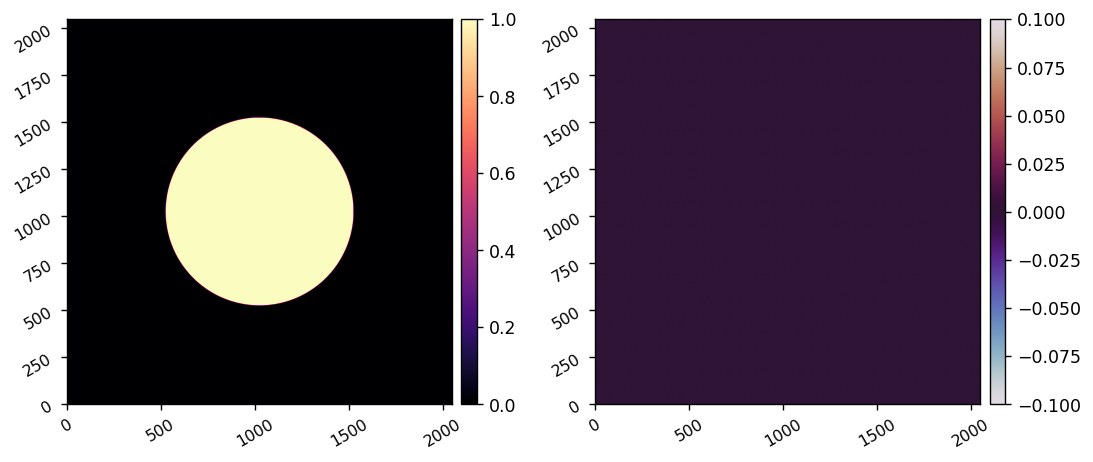

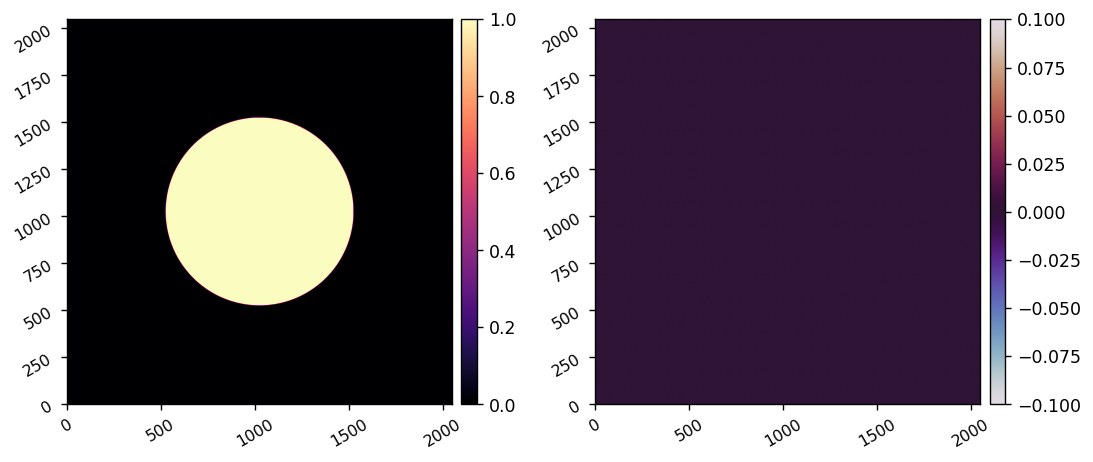

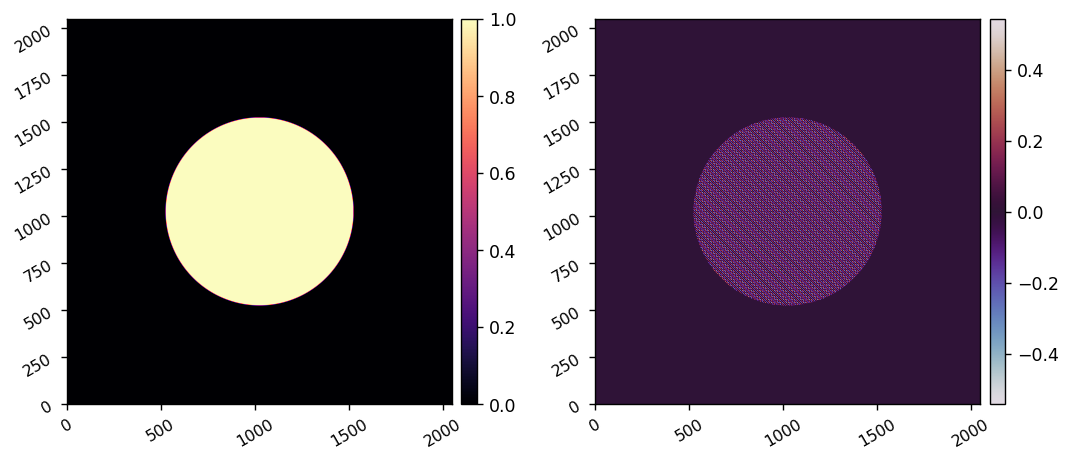

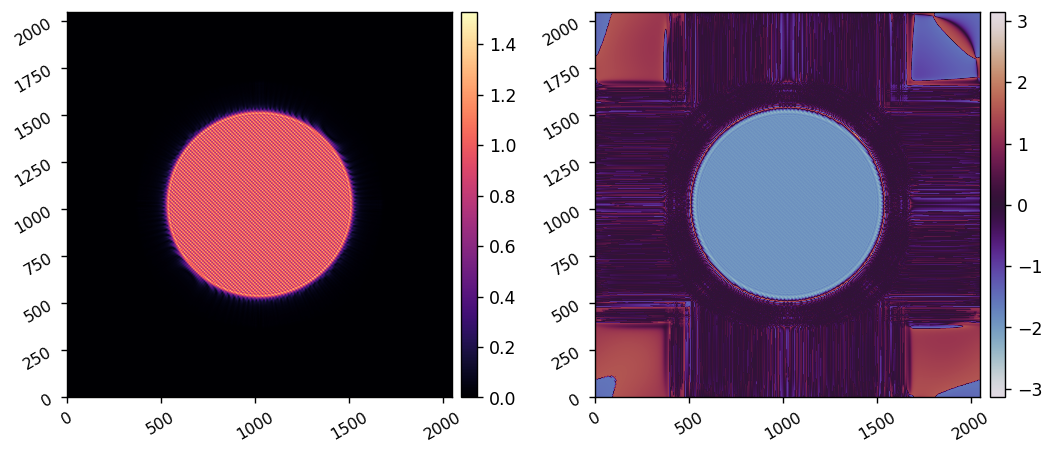

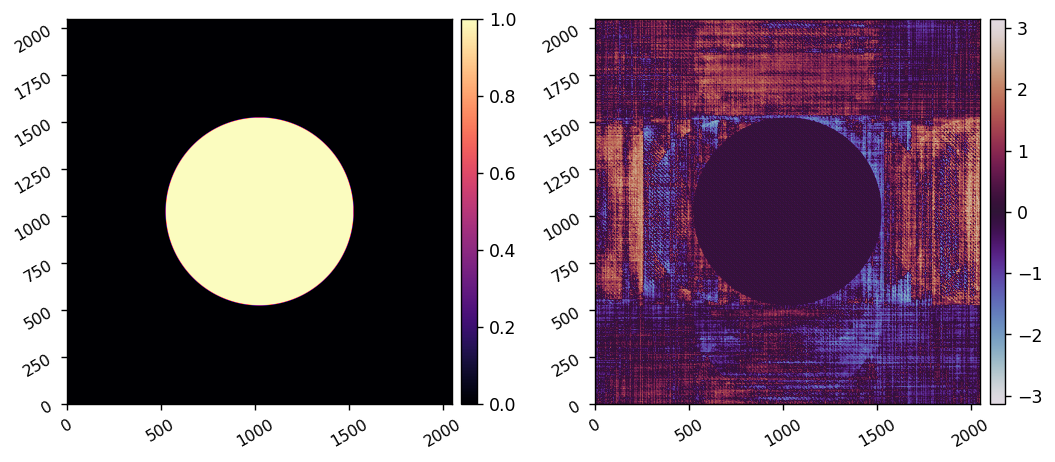

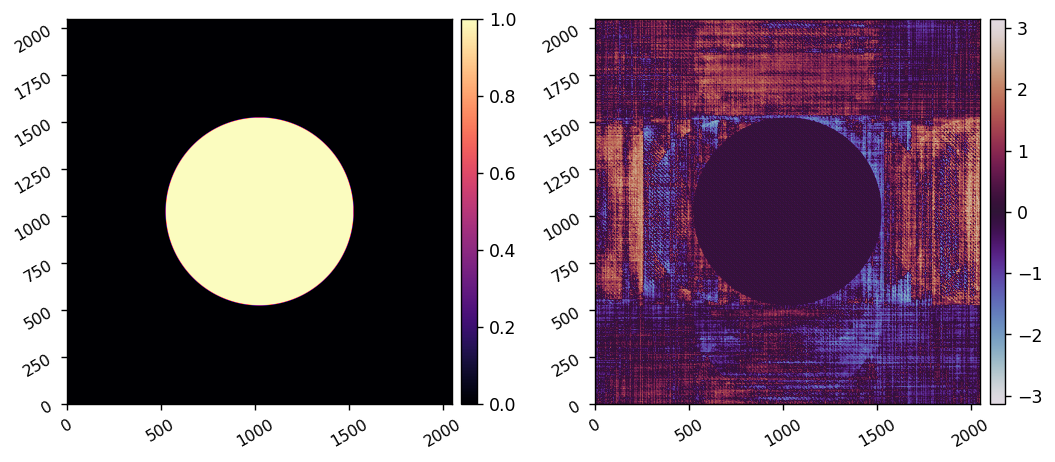

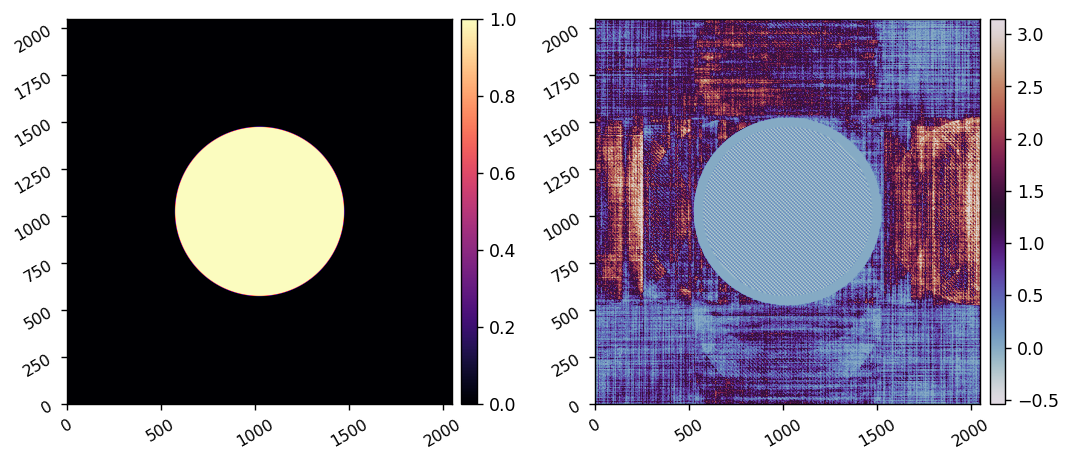

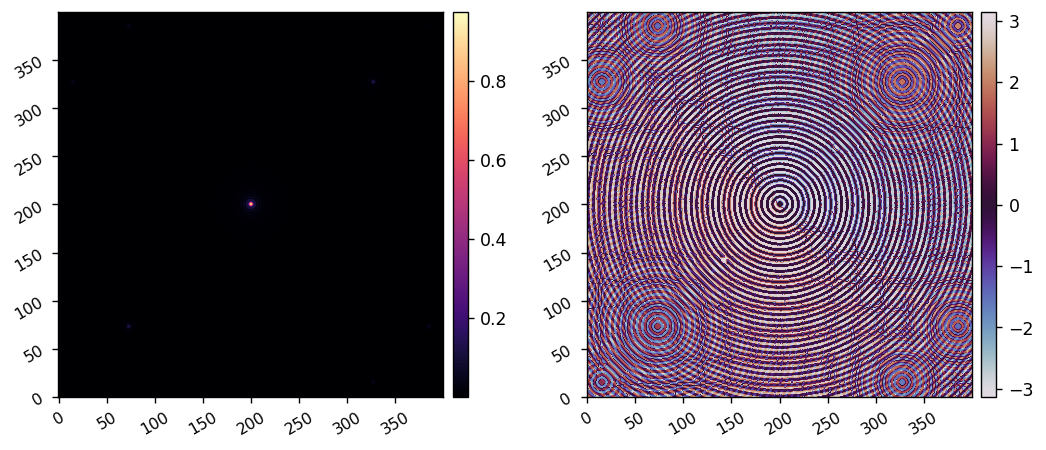

In [10]:
for i,wf in enumerate(wfs):
    imshow2(xp.abs(wf), xp.angle(wf),
            cmap1='magma', cmap2='twilight')

influence function sampling 8.138020833333334
Using the influence function supplied.
Including factor of 2 from reflection when computing OPD.
Using the influence function supplied.
Including factor of 2 from reflection when computing OPD.


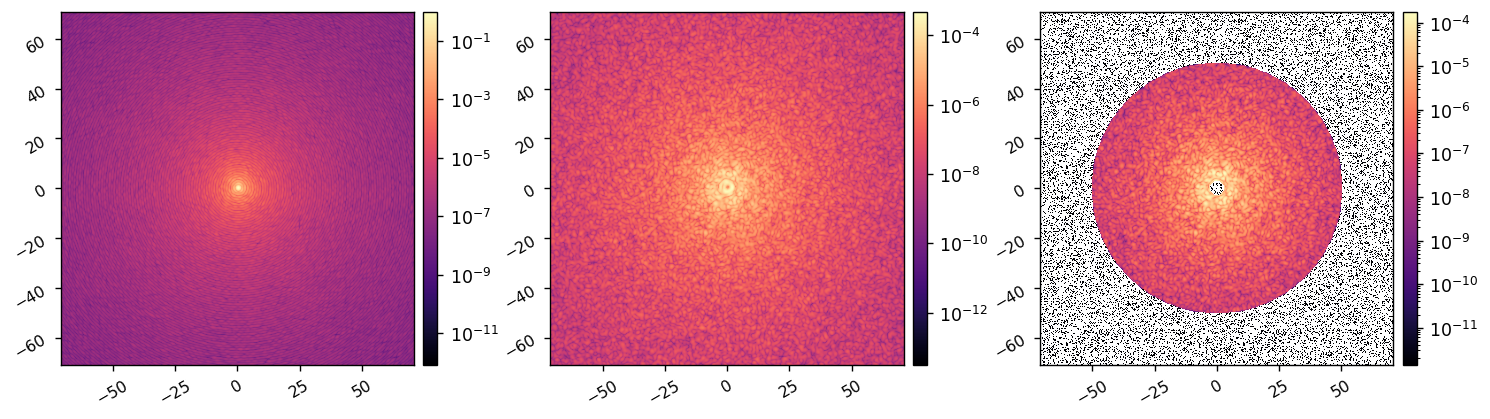

In [15]:
model = fraunhofer.CORO()
model.npsf = 400
model.reverse_parity = True
model.WFE = WFE

ref_psf = model.snap()
model.Imax_ref = xp.max(ref_psf)

model.use_fpm = True

ref_coro_im = model.snap()

control_mask = efc_utils.create_annular_focal_plane_mask(model, 3, 50)
imshow3(ref_psf/model.Imax_ref, ref_coro_im, control_mask*ref_coro_im, lognorm=True, pxscl=model.psf_pixelscale_lamD)

In [16]:
poke_modes = efc_utils.create_all_poke_modes(model.dm_mask, ndms=2)

In [17]:
reload(efc)
jac = efc.build_jacobian(model, 1e-9, poke_modes, control_mask, plot_responses=True,)

Calculating Jacobian: 
	Calculated response for mode 26080/26080. Elapsed time=1266.823 sec.
Jacobian built in 1266.823 sec


OutOfMemoryError: Out of memory allocating 32,665,239,552 bytes (allocated so far: 81,219,749,376 bytes).

In [12]:
model.reset_dms()

images = xp.array([ref_coro_im])
dm1_commands = xp.array([model.get_dm1()])
dm2_commands = xp.array([model.get_dm2()])
regs = xp.array([])

Beginning closed-loop EFC simulation.
	Running iteration 13/15.
	Mean NI of this iteration: 5.446e-11


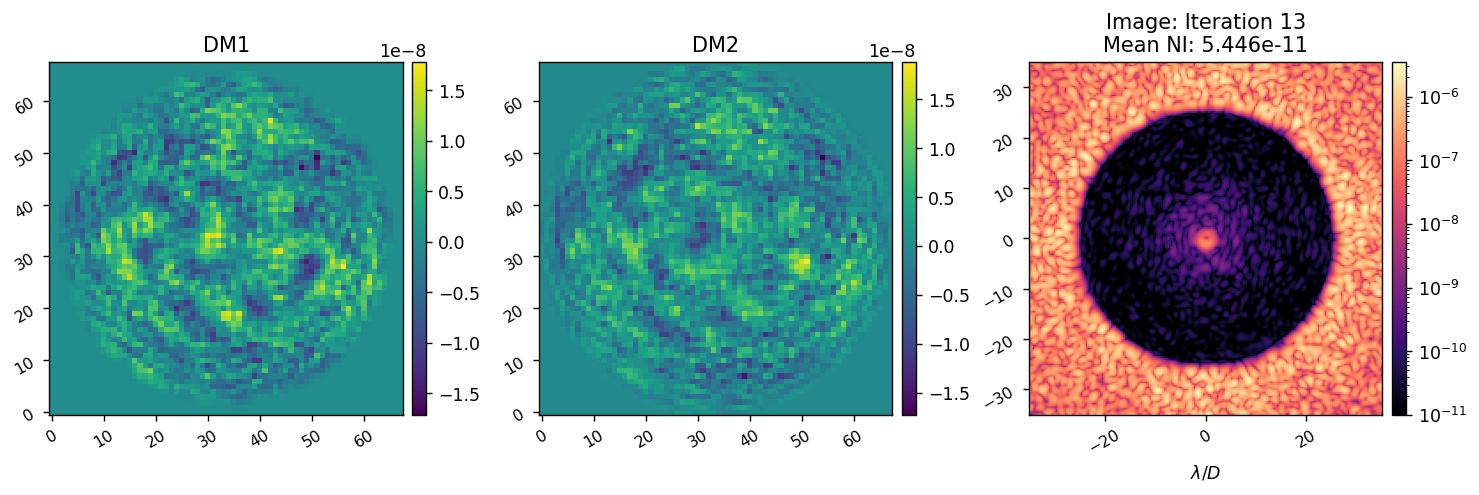

	Running iteration 14/15.
	Mean NI of this iteration: 2.354e-11


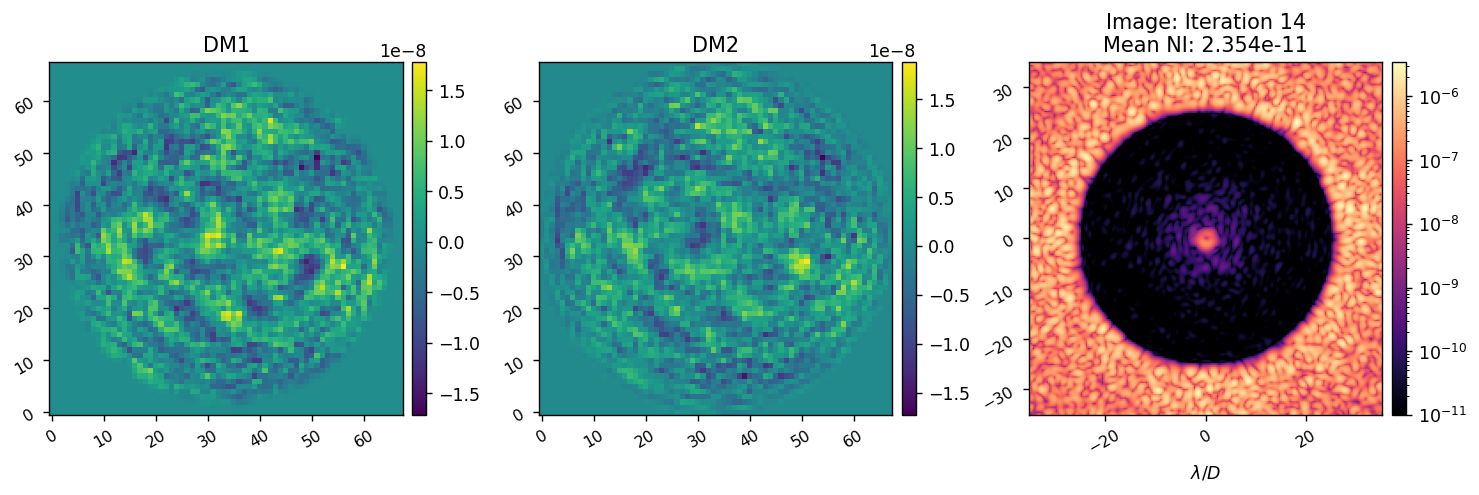

	Running iteration 15/15.
	Mean NI of this iteration: 1.113e-11


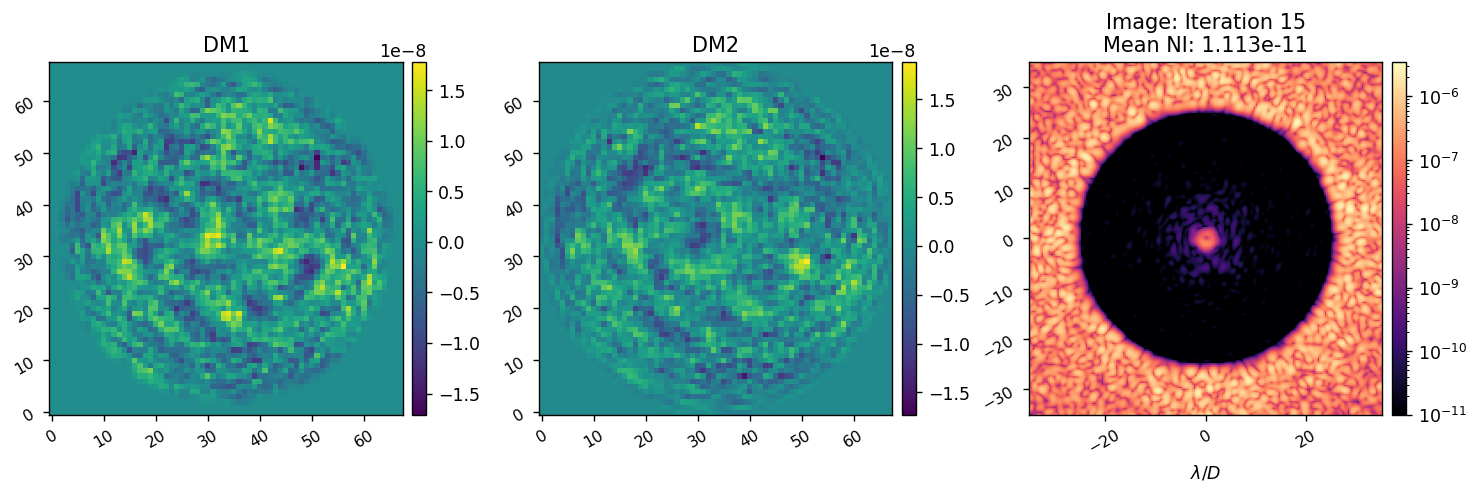

EFC completed in 4.774 sec.


In [17]:
reg_fun = efc_utils.beta_reg
# reg_conds = -1
# reg_conds = -2
reg_conds = -2.5
# reg_conds = -3
# reg_conds = -3.5
# reg_conds = -4.5
# reg_conds = -5

images, dm1_commands, dm2_commands, regs = efc.run(model, 
                                                    jac, 
                                                    reg_fun, reg_conds,
                                                    poke_modes,
                                                    # control_matrix,
                                                    control_mask, 
                                                    # est_fun=pwp_fun, est_params=pwp_params,
                                                    Imax_unocc=1,
                                                    loop_gain=0.5, 
                                                    leakage=0.0,
                                                    iterations=3, 
                                                    plot_all=True, 
                                                    # plot_sms=True,
                                                    # plot_radial_contrast=True,
                                                    old_images=images,
                                                    # old_efields=efields,
                                                    old_dm1_commands=dm1_commands,
                                                    old_dm2_commands=dm2_commands,
                                                    old_regs=regs,
                                                    )